## MAIZSIM sims - f2050

In [ ]:
import os
import yaml

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from SALib.analyze import rbd_fast

from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype.analysis import (identify_top_phenos,
                               top_pheno_prevalence,
                               prevalent_top_pheno,
                               rank_all_phenos)
from ideotype import DATA_PATH

In [2]:
#df_sims, df_issues = read_sims('/home/disk/eos8/ach315/upscale/sims/f2050')
#df_sims.to_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_f2050.csv', index=False)

In [ ]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_f2050.yml')
df_extended, df_stuck = parse_mature(df_all)

In [8]:
print(df_matured.shape[0]/df_all.shape[0])
print(df_extended.shape[0]/df_all.shape[0])
print(df_stuck.shape[0]/df_all.shape[0])

0.9913413193276586
0.00041396082895655997
0.00824471984338482


In [19]:
sims_present = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_present.csv')
sims_f2050 = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_f2050.csv')

<BarContainer object of 100 artists>

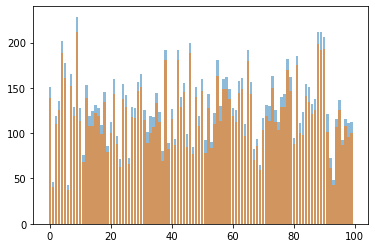

In [30]:
plt.bar(np.arange(100), sims_present.groupby('cvar').mean().dm_ear, alpha=0.5)
plt.bar(np.arange(100), sims_f2050.groupby('cvar').mean().dm_ear, alpha=0.6)

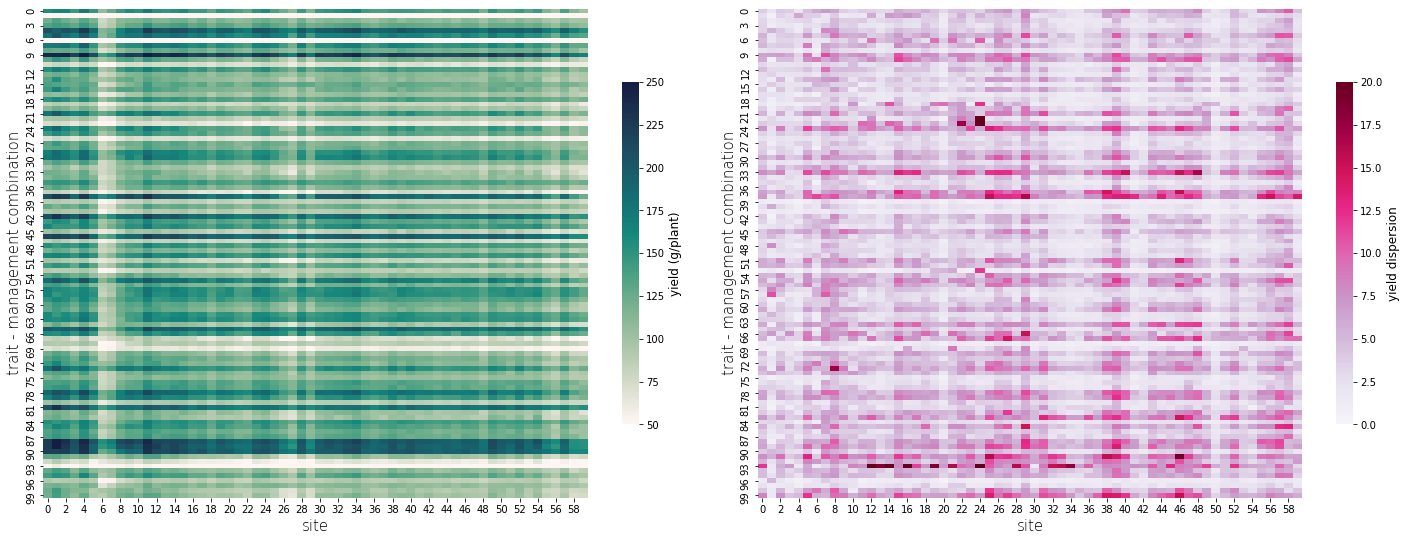

In [43]:
# Aggregate data
df = df_matured
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)
df_yield_means = pd.DataFrame(mx_mean)
df_yield_vars = pd.DataFrame(mx_disp)

# Data for plotting
dfs = [df_yield_means, df_yield_vars]
cmaps = [Tempo_10.mpl_colormap, 'PuRd']
vmins = [50, 0]
vmaxs = [250, 20]
labels = ['yield (g/plant)', 'yield dispersion']

# Visualiztion
fig = plt.figure(figsize=(25,9))
for index, df, cmap, vmin, vmax, label in zip([1,2], dfs, cmaps, vmins, vmaxs, labels):
    ax = fig.add_subplot(1,2,index)
    hm = sns.heatmap(df, cmap=cmap, 
                cbar_kws={'shrink': 0.7}, vmin=vmin, vmax=vmax)
    ax.set_xlabel('site', size=15, fontweight='light')
    ax.set_ylabel('trait - management combination', size=15, fontweight='light')
    ax.figure.axes[-1].set_ylabel(label, size=12)

fig.subplots_adjust(wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_mean_var_yield_unsorted.png', format='png', dpi=800)

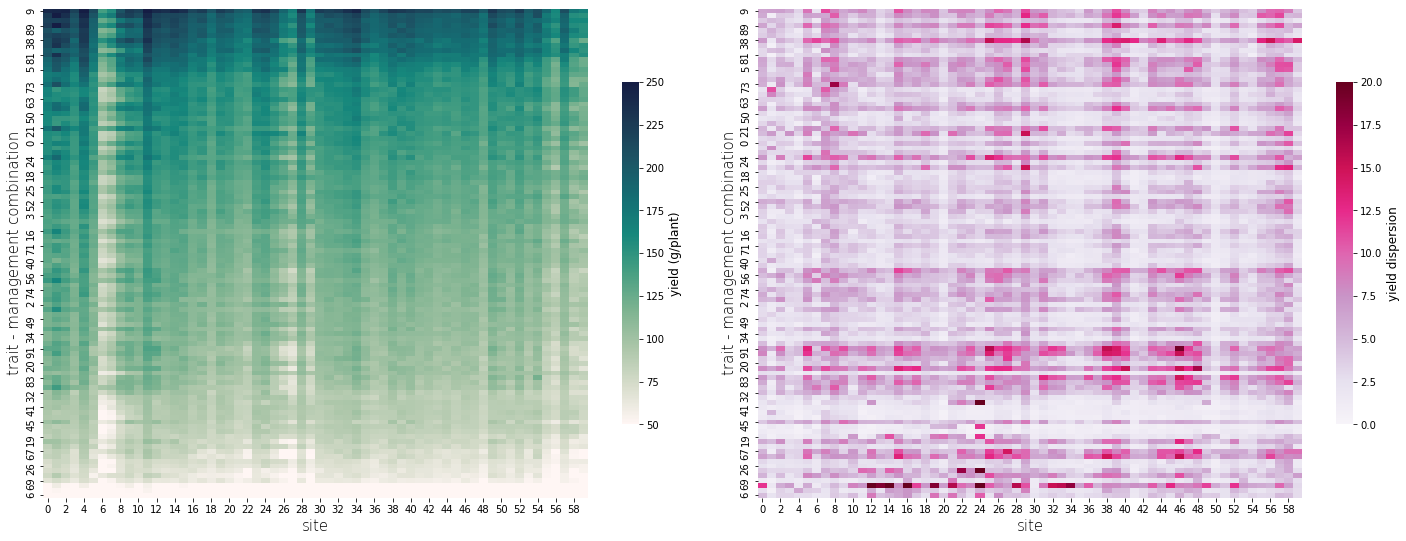

In [10]:
# Aggregate data
df = df_matured
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)
df_yield_means = pd.DataFrame(mx_mean)
df_yield_vars = pd.DataFrame(mx_disp)

# Sort data based on mean yield value
df_yield_means['mean'] = df_yield_means.mean(axis=1)
index_sortbymean = df_yield_means.sort_values(by=['mean'], axis=0, ascending=False).index

# Drop last column of calculated mean for plotting purpose
df_yield_means = df_yield_means.iloc[:,:-1]

# Data for plotting
dfs = [df_yield_means, df_yield_vars]
cmaps = [Tempo_10.mpl_colormap, 'PuRd']
vmins = [50, 0]
vmaxs = [250, 20]
labels = ['yield (g/plant)', 'yield dispersion']

# Figure
fig = plt.figure(figsize=(25,9))
for index, df, cmap, vmin, vmax, label in zip([1,2], dfs, cmaps, vmins, vmaxs, labels):
    ax = fig.add_subplot(1,2,index)
    hm = sns.heatmap(df.reindex(index_sortbymean), cmap=cmap, 
                cbar_kws={'shrink': 0.7}, vmin=vmin, vmax=vmax)
    ax.set_xlabel('site', size=15, fontweight='light')
    ax.set_ylabel('trait - management combination', size=15, fontweight='light')
    ax.figure.axes[-1].set_ylabel(label, size=12)

fig.subplots_adjust(wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_mean_var_yield.png', format='png', dpi=800)

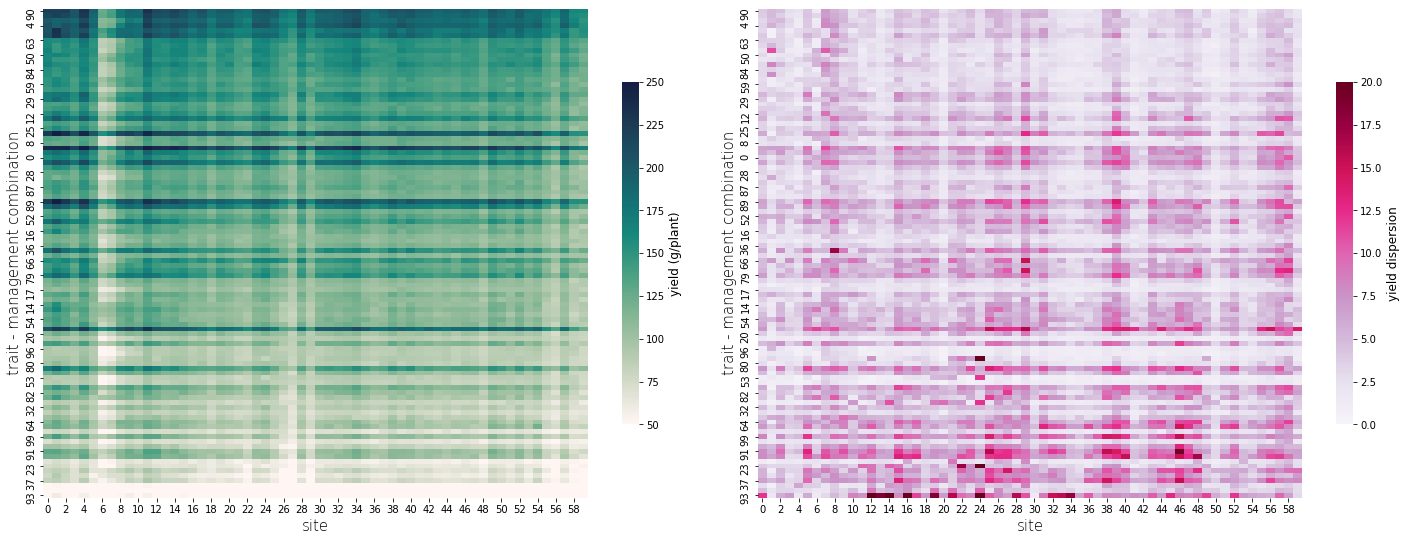

In [53]:
# Rank performance of all phenotypes
n_pheno = 100
w_yield = 0.5
w_disp = 0.5
run_name = 'f2050'
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Visualization
fig = plt.figure(figsize=(25,9))
for index, df, cmap, vmin, vmax, label in zip([1,2], dfs, cmaps, vmins, vmaxs, labels):
    ax = fig.add_subplot(1,2,index)
    hm = sns.heatmap(df.reindex(phenos_ranked), cmap=cmap, 
                cbar_kws={'shrink': 0.7}, vmin=vmin, vmax=vmax)
    ax.set_xlabel('site', size=15, fontweight='light')
    ax.set_ylabel('trait - management combination', size=15, fontweight='light')
    ax.figure.axes[-1].set_ylabel(label, size=12)

fig.subplots_adjust(wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_mean_var_performance.png', format='png', dpi=800)

Text(0.5, 1.0, 'extended gseason')

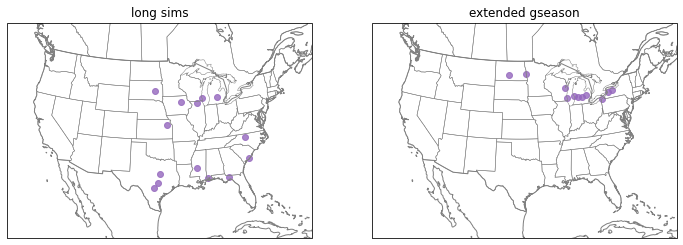

In [31]:
lat_stuck = df_stuck.groupby('site').mean().lat
lon_stuck = df_stuck.groupby('site').mean().lon
lat_extend = df_extended.groupby('site').mean().lat
lon_extend = df_extended.groupby('site').mean().lon

fig = plt.figure(figsize=(12,5))
extent = [-123, -72, 19, 53]

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax1.scatter(lon_stuck, lat_stuck, transform=ccrs.PlateCarree(), c='tab:purple', alpha=0.8)
ax1.set_extent(extent)
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('long sims')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax2.scatter(lon_extend, lat_extend, transform=ccrs.PlateCarree(), c='tab:purple', alpha=0.8)
ax2.set_extent(extent)
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('extended gseason')

Text(0.5, 1.0, 'mean simulated rainfed yield (tons/ha)')

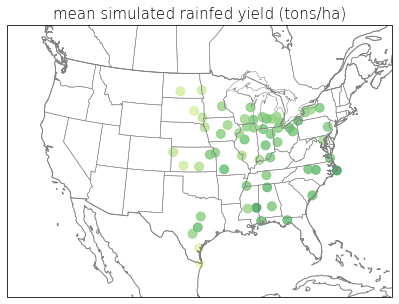

In [32]:
# Upscale yield from plant level (g/plant) to field level (tons/ha)
pop = 8  # plants/m2
ha_to_m2 = 10000
ton_to_g = 907185
ear_to_yield = 0.86  # only portion of ear converts into yield

# Visualize
fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
df_sub = df_all.groupby('site').mean()
sim_yield = [(ha_to_m2*pop*ear*ear_to_yield)/ton_to_g for ear in df_sub.dm_ear]

ax.scatter(df_sub.lon, df_sub.lat, 
           c=sim_yield, 
           cmap=YlGn_9.mpl_colormap,
           transform=ccrs.PlateCarree(), alpha=0.8, s=80,
           vmin=5, vmax=14)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('mean simulated rainfed yield (tons/ha)', fontsize=15, fontweight='light')

Text(0, 0.5, 'Yield (g/plant)')

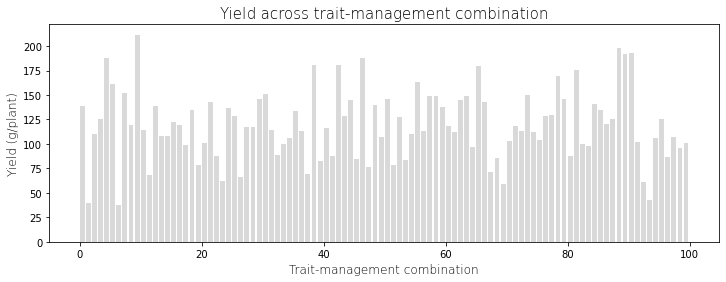

In [33]:
pheno_yield = df_all.groupby('cvar').mean().dm_ear
x = np.arange(len(pheno_yield))
width = 0.8

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
ax.bar(x+width/2, pheno_yield, width, color='#d9d9d9')
ax.set_title('Yield across trait-management combination', fontweight='light', fontsize=15)
ax.set_xlabel('Trait-management combination', fontweight='light', fontsize=12)
ax.set_ylabel('Yield (g/plant)', fontweight='light', fontsize=12)

Text(0, 0.5, 'Yield (g/plant)')

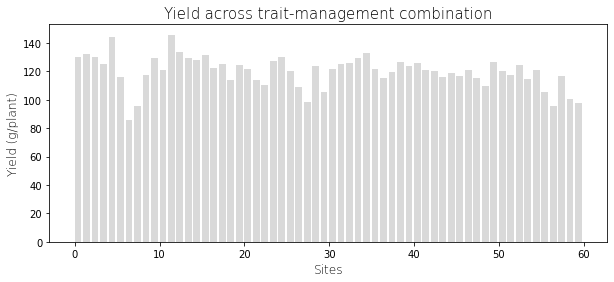

In [34]:
pheno_yield = df_all.groupby('site').mean().dm_ear
x = np.arange(len(pheno_yield))
width = 0.8

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.bar(x+width/2, pheno_yield, width, color='#d9d9d9')
ax.set_title('Yield across trait-management combination', fontweight='light', fontsize=15)
ax.set_xlabel('Sites', fontweight='light', fontsize=12)
ax.set_ylabel('Yield (g/plant)', fontweight='light', fontsize=12)

In [50]:
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'f2050'
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

In [51]:
# Parameters for identify_top_phenos
n_pheno = 5
n_phenos_toplot = 20
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('f2050', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

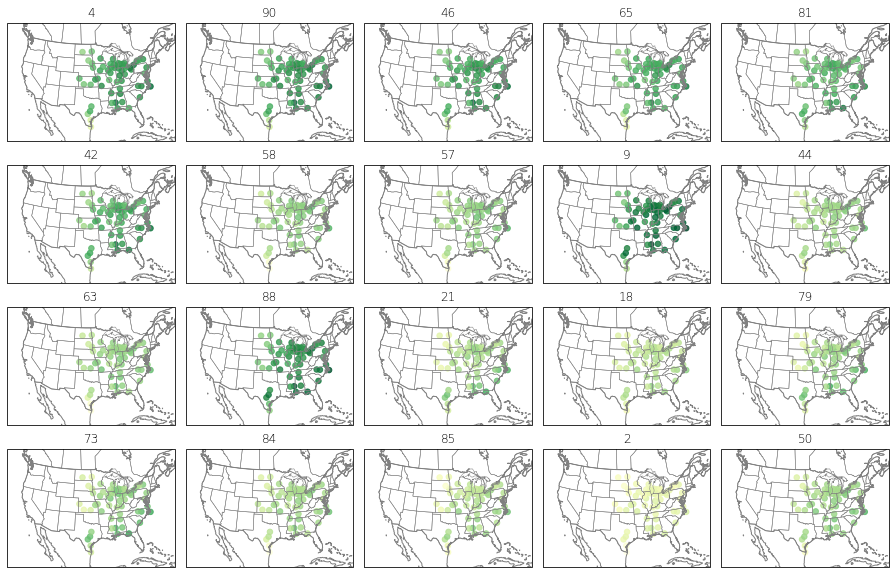

In [52]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,count+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=80, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(cvar, fontweight='light')

fig.subplots_adjust(wspace=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_yield_top_phenos_sortby_top_prevalence.png', format='png', dpi=800)

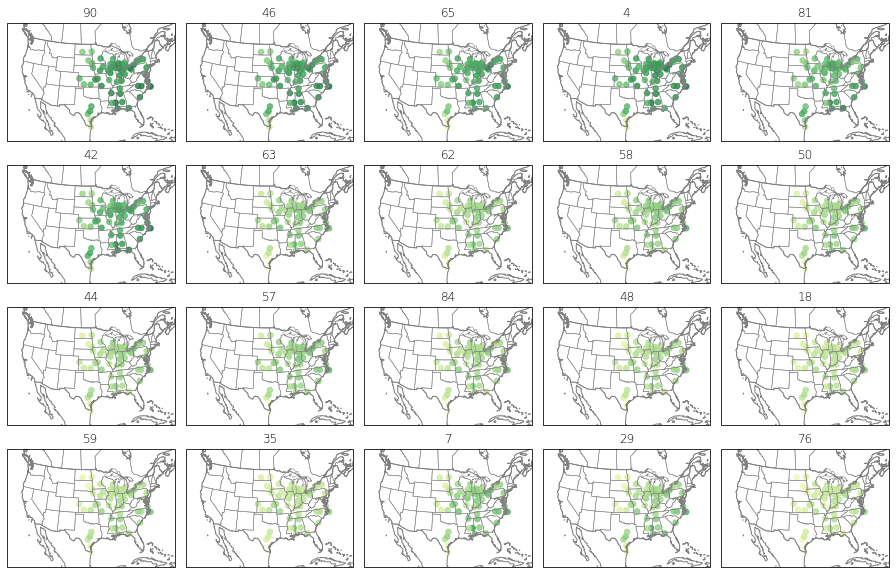

In [55]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(phenos_ranked[:20]):
    ax = fig.add_subplot(4,5,count+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=80, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(cvar, fontweight='light')

fig.subplots_adjust(wspace=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_yield_top_phenos.png', format='png', dpi=800)

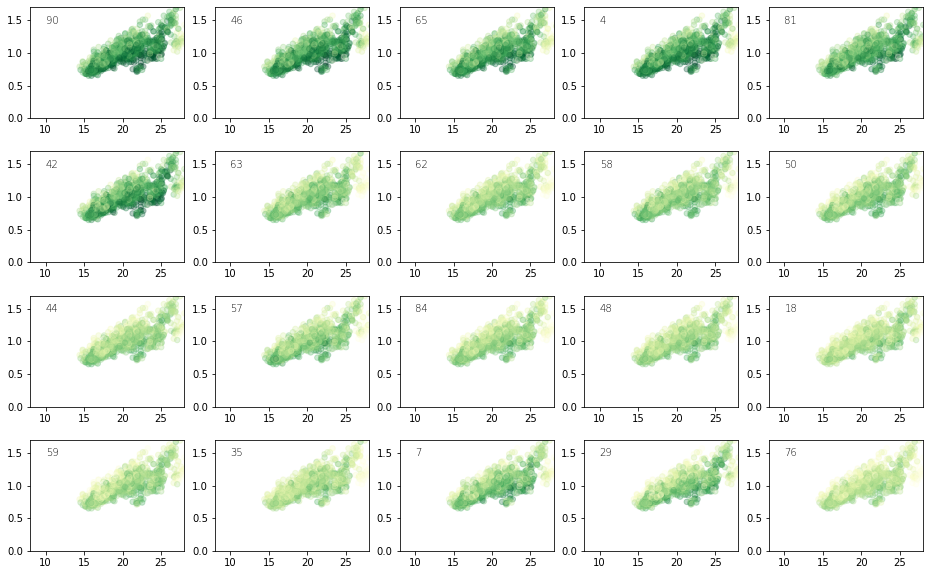

In [54]:
fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(phenos_ranked[:20]):
    ax = fig.add_subplot(4,5,count+1)
    df = df_all.query(f'cvar=={cvar}')
    sc = ax.scatter(df.temp, df.vpd, 
                    c=df.dm_ear, cmap=YlGn_9.mpl_colormap,
                    vmin=80, vmax=250, alpha=0.3, s=30)
    ax.set_xlim(8,28)
    ax.set_ylim(0,1.7)
#    ax.set_xlabel('temp', fontweight='light')
#    ax.set_ylabel('vpd', fontweight='light')
    ax.text(10,1.45,cvar, fontweight='light')

fig.subplots_adjust(hspace=0.3, wspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_cspace_top_phenos.png', format='png', dpi=800) 